In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datarobot as dr
from IPython.display import display, Image

# DataRobot Analysis of BuzzFeed's recent spy-plane identification analysis

[Source Article: BuzzFeed News Trained A Computer To Search For Hidden Spy Planes. This Is What We Found](https://www.buzzfeed.com/peteraldhous/hidden-spy-planes?utm_term=.pbMQJ3WKp#.lgdep1d6m)

## Background 
BuzzFeed released a dataset and jupyter notebook recently that analyzed public flight data to identify potential spy planes.  This built on previous BuzzFeed stories on the same topic, which identified and verified spy planes. <br><br> Features from the 100 previously verified surveillance-planes were used as positive training examples in train.csv, as well as 500 randomly selected planes from a sample of 20,000.

BuzzFeed conducted some very clever feature engineering (described below), and used random forests to train on the 600 plane training set using a train/validation split (due to time constraints no cross-validation was done), and then ran predictions on the remaining 19,799 aircraft in their sample. 

BuzzFeed identified 69 likely surveillance planes, and 19,091 normal aircraft flights.  

[Github](https://buzzfeednews.github.io/2017-08-spy-plane-finder)<br>
[Original Article](https://www.buzzfeed.com/peteraldhous/spies-in-the-skies?utm_term=.phVp8l3DE#.ri7okwGBp)


# Objective
BuzzFeed's data gathering and feature engineering were extremeley clever, and highlight a critical aspect of datas cience: developing new features from your dataset that enhance predictions.  In their article, they indicate a few areas of further study that they would like to do but were not able to.  In particular, 

 * Use cross-validation on the training data set to get more generalizable predictions.  BuzzFeed fit their model on the entire training data set to set model parameters, and then ran predictions based on that fit.  While the bagging internal to Random Forests is a robust procedure against overfitting, we will use cross-validation.
 * Evaluate multiple models.  Random Forests is extremely powerful, but DataRobot will evaluate ~ 70 models to see which performs best.
 
We will implement these two tasks and see if doing so helps answer the following questions: 

* Can we build a more robust model using DataRobot that better predicts surveillance planes?
* Can we identify new planes that may have been missed? 
* Can we identify new important features in the model, and do our important features line-up with BuzzFeed's important features?

# First, a review of the data

(per [BuzzFeed's Github)]([Github](https://buzzfeednews.github.io/2017-08-spy-plane-finder)
..We took a random sample of 500 aircraft and calculated the following for each one:

* **duration** of each flight segment recorded by Flightradar24, in minutes.
* **boxes**- Area of a rectangular bounding box drawn around each flight segment, in square kilometers.
* Finally, we calculated the following variables for each of the aircraft in the larger filtered dataset:


* **duration1,duration2,duration3,duration4,duration5** Proportion of flight segment durations for each plane falling into each of five quantiles calculated from duration for the sample of 500 planes. The proportions for each aircraft must add up to 1; if the durations of flight segments for a plane closely matched those for a typical plane from the sample, these numbers would all approximate to 0.2; a plane that mostly flew very long flights would have large decimal fraction for duration5.
* **boxes1,boxes2,boxes3,boxes4,boxes5** Proportion of bounding box areas for each plane falling into each of five quantiles calculated from boxes for the sample of 500 planes.
* **speed1,speed2,speed3,speed4,speed5** Proportion of speed values recorded for the aircraft falling into each of five quantiles recorded for speed for the sample of 500 planes.
* **altitude1,altitude2,altitude3,altitude4,altitude5** Proportion of altitude values recorded for the aircraft falling into each of five quantiles recorded for altitude for the sample of 500 planes.
* **steer1,steer2,steer3,steer4,steer5,steer6,steer7,steer8** Proportion of steer values for each aircraft falling into bins set manually, after observing the distribution for the sample of 500 planes, using the breaks: -180, -25, -10, -1, 0, 1, 22, 45, 180.
* **flights** Total number of flight segments for each plane.
* **squawk_1** Squawk code used most commonly by the aircraft.
* **observations** Total number of transponder detections for each plane.
* **type** Aircraft manufacter and model, if identified, else unknown.
The resulting data for 19,799 aircraft are in the file **planes_features.csv**.

# Training Data
As training data, drawn from **planes_features.csv**, we used 97 fixed-wing FBI and DHS planes from our previous story, given a class of  surveil, and a random sample of 500 other planes, given a class of other.

Data identifying these planes is in the file **train.csv**.

In [2]:
#load training data and merge with planes_features
def get_train_data(file1, file2):
    train=pd.read_csv(file1)
    print("Training Columns are", train.columns)
    
    all_planes = pd.read_csv(file2)
    #print(feats.head())
    
    merged =train.merge(all_planes, on = 'adshex')
    print("Training data shape is ", train.shape)
    print("FAA plane features shape is ", all_planes.shape)
    print('Merged shape is ', merged.shape)
    
    print(merged.head())
    return merged, all_planes

train_data, all_planes = get_train_data('train.csv', 'planes_features.csv')

Training Columns are Index(['adshex', 'class'], dtype='object')
Training data shape is  (597, 2)
FAA plane features shape is  (19799, 33)
Merged shape is  (597, 34)
   adshex    class  duration1  duration2  duration3  duration4  duration5  \
0  A00C4B  surveil   0.450000   0.125000   0.025000   0.025000   0.375000   
1  A0AB21  surveil   0.523810   0.000000   0.047619   0.095238   0.333333   
2  A0AE77  surveil   0.262295   0.196721   0.081967   0.114754   0.344262   
3  A0AE7C  surveil   0.521739   0.086957   0.043478   0.043478   0.304348   
4  A0C462  surveil   0.250000   0.083333   0.500000   0.083333   0.083333   

     boxes1    boxes2    boxes3  ...     steer3    steer4    steer5    steer6  \
0  0.475000  0.250000  0.250000  ...   0.303922  0.154544  0.033312  0.088024   
1  0.714286  0.095238  0.047619  ...   0.166456  0.309313  0.008007  0.078382   
2  0.639344  0.295082  0.032787  ...   0.279779  0.209981  0.009416  0.037900   
3  0.565217  0.043478  0.260870  ...   0.238111 

### The planes_features.csv contains the data we want to predict, however we need to remove the samples used in training, as well as known federal planes in the file feds.csv. It turns out all of the known federal planes in feds.csv are not in the dataset of planes_features.csv

In [3]:
#count check
print("Total number of planes in all_planes: ", all_planes.shape[0])

#read in federal planes we want to exclude
feds = pd.read_csv('feds.csv')

#identify erroneous planes
print("Number of federal planes not in the full data set: ", len(set(feds.adshex).difference(all_planes.adshex)))

#only keep the federal planes that are actually in the complete data set of all_planes
feds_good = set(feds.adshex).intersection(all_planes.adshex)

print("Additional federal planes to exclude, that were not used in trainig: ", len(feds_good.difference(train_data.adshex)))

#combine the federal planes with the data used in training to index out from our prediction set
bad_planes = feds_good.union(train_data.adshex)
print("Number of training planes to exclude: ", len(train_data.adshex))
print("Total planes to exclude: ", len(bad_planes))

#get a list of good columns
goodcols = (set(all_planes.adshex).difference(bad_planes)) #in all_planes but excluding federal planes and training data
print("Number of new planes to predict:", len(goodcols))

#create a clean prediction data set
planes2predict = all_planes[all_planes.adshex.isin(goodcols)]
planes2predict.head()
print(planes2predict.shape)


Total number of planes in all_planes:  19799
Number of federal planes not in the full data set:  60
Additional federal planes to exclude, that were not used in trainig:  42
Number of training planes to exclude:  597
Total planes to exclude:  639
Number of new planes to predict: 19160
(19160, 33)


Now that we have safely eliminated the training and known federal planes from our prediction set, we can fit a model in DataRobot and make predictions

# Here we will run multiple models in DataRobot, evaluate their performance, and select the best model for predictions. 
# As well, we will compare our best model to our default R Random Forest model that BuzzFeed used

In [4]:
#connect to DataRobot
import config as c
c.DATAROBOT_ENDPOINT

#verify connection
dr.Client(token = c.DATAROBOT_API_TOKEN, endpoint= c.DATAROBOT_ENDPOINT)

### Since we have a small dataset (597 rows) for training, we need to adjust the default datarobot cross validation settings to ensure we can return reason codes for our new predictions. We normally use a holdout set for our best model, but with this small dataset we will use 5 folds CV with no holdout.  We'll also compare to the loss from our default autopilot settings, which uses 5 fold CV with a 20% holdout set.

### 5 folds CV, Stratified Sampling, no holdout

In [99]:
# set holdout percent to 0
custom_cv = dr.StratifiedCV(holdout_pct=0, reps=5, seed=0)
project = dr.Project.start(sourcedata= train_data,
                           partitioning_method = custom_cv,
                          target = 'class',
                        worker_count = 20,
                          project_name='DR_Surveillance_Planes_No_Holdout_Strat')

In [101]:
project.get_status()

{'autopilot_done': False,
 'stage': 'modeling',
 'stage_description': 'Ready for modeling'}

### 5 Folds CV, Stratified Sampling, 20% Holdout

In [70]:
project2 = dr.Project.start(sourcedata= train_data,
                           #partitioning_method = custom_cv, use default autopilot
                          target = 'class',
                          worker_count = 20,
                          project_name='DR_Surveillance_Planes_AutoPilot')

In [267]:
#since we had to return to an existing project, grab the info
project = dr.Project.get(project_id='59b57e5ac808911ad82f99af')
project2 = dr.Project.get(project_id='59b321bcc808916d20a79aac')
print("project= {} and project2 = {}".format(project.project_name, project2.project_name))


project= DR_Surveillance_Planes_No_Holdout_Strat and project2 = DR_Surveillance_Planes_AutoPilot


In [268]:
project2.partition

{'cv_method': 'stratified',
 'holdout_pct': 19.933,
 'reps': 5,
 'validation_type': 'CV'}

In [287]:
def get_results(project):
    """Args: A DataRobot project object
    
       returns: A dataframe sorted by log loss for cross-validation"""
    #extract featurelist
    feature_lists = project.get_featurelists()
    
    #get informative features, the default for autopilot
    f_list = [lst for lst in feature_lists if
                     lst.name == 'Informative Features'][0]
    
    #get models
    models = project.get_models()
    #get list of models that ran our feature list, Informative Features
    flist_models = [model for model in models if model.featurelist_id == f_list.id]
    
    #print results
    val_scores = pd.DataFrame([{'model_type': model.model_type,
                           'model_id': model.id,
                           'sample_pct': model.sample_pct,
                           'featurelist': model.featurelist_name,
                           'val_logloss': model.metrics['LogLoss']['validation'],
                           'cross_val_logloss': model.metrics['LogLoss']['crossValidation']}
                           #for model in flist_models if model.metrics['LogLoss']['crossValidation'] is not None])
                            for model in flist_models if model.metrics['LogLoss'] is not None])
    return val_scores.sort_values(by='cross_val_logloss')

In [270]:
autopilot_df = get_results(project2) # 5 folds CV, 20% holdout, no reason codes
autopilot_df[0:2]

,cross_val_logloss,featurelist,model_id,model_type,sample_pct,val_logloss
2,0.102724,Informative Features,59b322c43e945a7dd79dde59,ENET Blender,63.987,0.14789
3,0.106538,Informative Features,59b322c43e945a7dd79dde53,AVG Blender,63.987,0.15000


In [271]:
custom_cv_df = get_results(project) # 5 folds CV, no holdout, will produce reason codes
custom_cv_df[custom_cv_df.sample_pct== 79.9][0:2] #don't show scores that were used for 100% models

,cross_val_logloss,featurelist,model_id,model_type,sample_pct,val_logloss
2,0.092090,Informative Features,59b57f308962b210850c1cd1,ENET Blender,79.9,0.10228
1,0.092778,Informative Features,59b57f2a8962b210850c1ccb,AVG Blender,79.9,0.09975


### Our 5 fold CV, no holdout model achieved the best cross_val log loss of 0.092.  We'll use this model for predictions, and take a peak at performance.  We'll also train it on 100% of the data to use for our predictions. First, let's evaluate our models

# Model Evaluation
## Log Loss
### DataRobot allows us to run dozens of open source models with the press of a button, and as such the metric we use to compare them is important. Log loss or cross-entropy loss is a good metric, as it compares the predicted probabilities to the class membership.  

$$ -\frac{1}{N} \sum_{i=1}^N \log [y_i \log \ p_i + (1-y_i) log (1-p_i)]    $$

In [275]:
#quick function to view our models we've ran
def plot_results(df, metric= 'val_logloss'):
    
    """Args: A dataframe from the function get_results(), either metric 'cross_val_logloss', or 'val_logloss'
    
       Returns: a horizontal bar plot of model performance"""
    
    %matplotlib inline
    #from matplotlib.pyplot import subplots
    sns.set(style="darkgrid")

    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(6, 10))

    # Plot the total crashes
    sns.set_color_codes("pastel")
    #sns.barplot(x="cross_val_logloss", y="model_type", data=custom_cv_df[custom_cv_df.sample_pct== 79.9], palette= 'Blues_d') 
    sns.barplot(x=metric, y="model_type", data=df[df.sample_pct== 79.9], palette= 'Blues_d') 



    # Add a legend and informative axis label
    ax.legend(ncol=2, loc="lower right", frameon=True)
    if metric == 'cross_val_logloss':
        ax.set(xlim=(0, max(df.cross_val_logloss)+0.1), 
          ylabel="Top {} Models and Ensembles of {} Models Evaluated".format(len(df.model_type.unique()),len(df.val_logloss)),
           xlabel="5 fold CV log loss score")
    else:
        ax.set(xlim=(0, max(df.val_logloss)+0.1),
               ylabel="Top {} Models and Ensembles of {} Models Evaluated".format(len(df.model_type.unique()),len(df.val_logloss)),
           xlabel="Validation log loss score")
    #sns.despine(left=True, bottom=True)

/Users/chandler.mccann/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


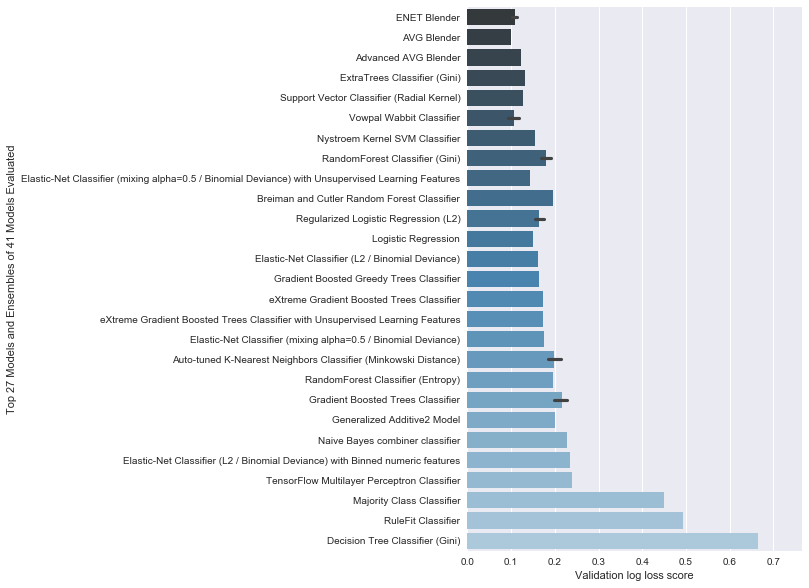

In [286]:
plot_results(custom_cv_df)

/Users/chandler.mccann/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


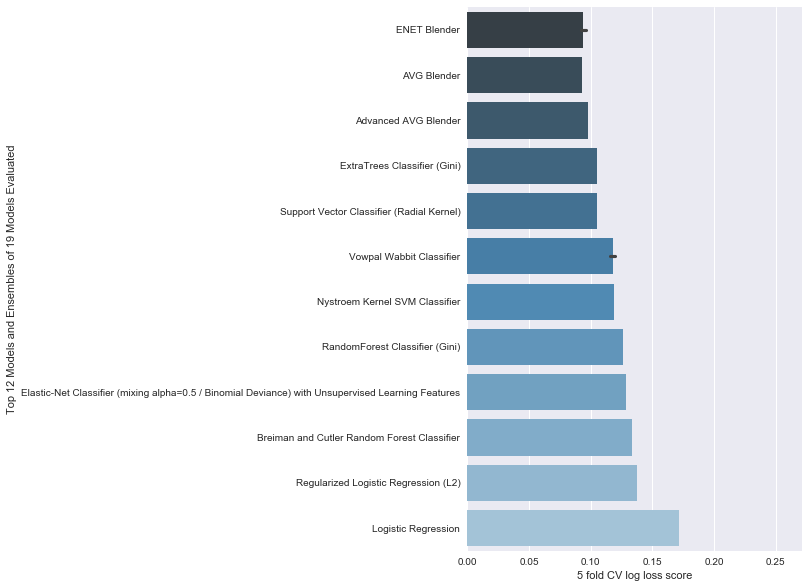

In [277]:
plot_results(custom_cv_df.dropna().sort_values(by='cross_val_logloss'), 'cross_val_logloss')

## Our best performing model was an ensemble of our top 3 individual models (by CV score): ExtraTrees Classifier (Gini), Vowpal Wabbit Classifier, and a Support Vector Classifier (Radial Kernel), all fed in to an ElasticNet Classifier using (L2/ Binomial Deviance)

![Enet](ENET_Blue_Print.png "title")

# Confusion Matrix
## We achieved a positive class error(1- sensitivity) of 10.3% vs BuzzFeeds 20.6% for the surveillance plane class

![ROC](ROC_Curve.png)
![BF_ROC](BuzzFeedCM.png "BuzzFeed's Confusion Matrix")

# Accuracy across range of predictions
## Lift charts are a useful way to understand how our model makes predictions along all possible ranges of probabilities.

### The Random Forest lift chart is below. Predictions are sorted high to low, and sorted in to deciles.  The orange line is the mean actual occurrence of surveillance planes in the validation data, and the blue line is the average predicted probabilities in that decile.  We can see that around the 7th decile, the Random Forest model begins to overpredict

![RandomForest](RF_lift.png)

### The Elastic Net Blender, however, has a much tighter fit to the predicted values and begins to predict the presence of surveillance planes much closer to their actual occurrence in the data set.
![ENET_lift](ENET_Lift2.png)

In [278]:
Image(filename='img/ModelCompare2.png')
!ls

BuzzFeedCM.png
DR_Surveillance_Planes_No_Holdout_Strat_Breiman_and_Cutler_Random_Forest_Classifier_(37)_100_Informative_Features_predict_RC_3_lt_0.003_gt_0.524.csv
DR_Surveillance_Planes_No_Holdout_Strat_ENET_Blender_(24+25+32)_(68)_79.9_Informative_Features_predict.csv
DR_Surveillance_Planes_No_Holdout_Strat_ENET_Blender_(85+86+87)_(88)_100_Informative_Features_predict_RC_3_lt_0.573_gt_0.574.csv
DR_results_ExtraTrees.csv
DataRobot_BuzzFeed_20170907.ipynb
ENET_Blue_Print.png
ENET_Feat_Impact.png
ENET_Lift.png
ENET_Lift2.png
ENET_Squawk1_Xray.png
ENET_Steer2_Xray.png
ENET_Type_Xray.png
FAA_DR.ipynb
ModelCompare2.png
Model_Compare.png
RF_Feat_Importance.png
RF_lift.png
ROC_Curve.png
__pycache__
candidates.csv
candidates_annotated.csv
config.py
faa-registration.csv
feds.csv
img
planes_features.csv
predict.csv
train.csv
training_merged
training_merged.csv


# NOT ACCURATE, DUAL LIFT SORTED BY DIFFERENCE IN PREDICTIONS
## In the dual lift chart above, when we compare our blended-model (left) with the RandomForest model on the right, we see that they are overpredicting on non-surveillance planes, and underpredicting roughly 20% less than our model, which lines up with our confusion matrix results.  

## Importantly, the RandomForest model is overpredicting on the low-end (10 percentile), returning similar probabilities to their 80th-90th percentile. We'll see this difference in our predictions.

## This is not exactly apples to apples as DataRobot naturally does some data preparation with the default Random Forest model, but is a close approximation to the BuzzFeed model


# Make Predictions 

In [256]:
#custom_cv_df[custom_cv_df.model_obj=='']
model_id = custom_cv_df.model_id[2]
print(model_id)
model = dr.Model.get(project=project.id,
                     model_id=model_id)
print(model.sample_pct, model.model_type) #79.9

model_100_id=custom_cv_df.model_id[8]
print(model_100_id)
model_100 = dr.Model.get(project=project.id,
                     model_id=model_100_id)
print(model_100.sample_pct, model_100.model_type) #what we'll use for predictions

#buzzfeed model
bf_model_id= custom_cv_df.model_id[17]
print(bf_model_id)
bf_model = dr.Model.get(project=project.id,
                     model_id=bf_model_id)
print(bf_model.sample_pct, bf_model.model_type)


59b57f308962b210850c1cd1
79.9 ENET Blender
59b6f112c8089117b1383188
100.0 ENET Blender
59b57e7cf84a9634c870eafa
79.9 Gradient Boosted Greedy Trees Classifier


In [152]:
# #upload dataset to DR
# dataset = project.upload_dataset(planes2predict)
# #request predictions
# predict_job = model.request_predictions(dataset.id)
# predictions = predict_job.get_result_when_complete()
# predictions


In [24]:
#in order to return the adshex, we needed to download the predictions and reason codes from the GUI
preds = pd.read_csv('DR_Surveillance_Planes_No_Holdout_Strat_ENET_Blender_(85+86+87)_(88)_100_Informative_Features_predict_RC_3_lt_0.573_gt_0.574.csv')

In [25]:
preds.head()

,row_id,adshex,Prediction,Reason 1 Strength,Reason 1 Feature,Reason 1 Value,Reason 2 Strength,Reason 2 Feature,Reason 2 Value,Reason 3 Strength,Reason 3 Feature,Reason 3 Value
0,0,A,0.003921,--,boxes5,'0.677215189873',--,speed5,'0.794582201087',--,steer5,'0.097316576087'
1,1,A00000,0.008108,---,squawk_1,'0',--,steer5,'0.116115505575',++,flights,'392'
2,2,A00008,0.001705,--,boxes5,'0.5',--,squawk_1,'0',--,duration1,'0.125'
3,3,A0001E,0.004821,--,boxes5,'0.4',--,speed5,'0.701587301587',--,duration1,'0.1'
4,4,A0002B,0.030702,++,squawk_1,'2356',--,steer5,'0.112341772152',--,steer2,'0.00949367088608'


In [58]:
#add in our prediction threshold for surveillance planes. For our cross-validation model, 
# 0.4380 maximized the F1-Score. On our fully trained model, 0.2131 does. 
preds['spyplane'] = np.where(preds.Prediction >=0.4380, 1,0)

In [59]:
preds.sort_values(by='Prediction', ascending=False).head()

,row_id,adshex,Prediction,Reason 1 Strength,Reason 1 Feature,Reason 1 Value,Reason 2 Strength,Reason 2 Feature,Reason 2 Value,Reason 3 Strength,Reason 3 Feature,Reason 3 Value,spyplane
11657,11657,A7D925,0.993074,+++,type,'T206',++,steer2,'0.315046917633',++,steer1,'0.16684043568',1
9593,9593,A63E52,0.988268,++,type,'T206',++,steer2,'0.219209726444',++,steer1,'0.207294832827',1
2169,2169,A13A84,0.980787,++,steer2,'0.208291956306',++,type,'C208',++,steer5,'0.0235849056604',1
7129,7129,A497C0,0.979861,++,squawk_1,'5367',++,steer2,'0.204642996488',++,steer5,'0.0406749902458',1
2121,2121,A13098,0.978376,++,steer2,'0.176803394625',++,squawk_1,'4415',++,steer5,'0.019330504479',1


In [108]:
#let's compare our pics to buzzfeeds
buzzfeed_pics = pd.read_csv('candidates_annotated.csv')
#
print(buzzfeed_pics.shape)
buzzfeed_pics.tail()

(100, 8)


,other,surveil,adshex,squawk_1,name,reg,notes,Unnamed: 7
95,0.5485,0.4515,A4F17E,1200,HARDING ROY A DBA,N4177R,Helicopter tours,NaN
96,0.5505,0.4495,A287FC,0,SUNDANCE AIRPORT LLC,N262SA,NaN,NaN
97,0.5540,0.4460,A56412,2451,AVIATION SPECIALTIES INC,N4466A,Linked to rendition flights by CIA,NaN
98,0.5575,0.4425,A94471,4401,MIDWEST AERIAL IMAGING,N6968A,DHS front,NaN
99,0.5615,0.4385,ABA8EC,0,MAXIM AVIATION LLC,N850SD,Skydiving,NaN


In [279]:
buzzfeed_pics

,other,surveil,adshex,squawk_1,name,reg,notes,Unnamed: 7
0,0.0750,0.9250,A4FB3C,5310,CITY OF MESA ARIZONA,N42WB,Local law enforcement,NaN
1,0.0995,0.9005,A13098,4415,NaN,NaN,"Using federal law enforcement squawk, identity...",NaN
2,0.1010,0.8990,A7D925,230,ORANGE COUNTY SHERIFFS DEPARTMENT RNSP,N6045C,Local law enforcement,NaN
3,0.1085,0.8915,A63E52,5306,CHAPARRAL AIR GROUP,N501GW,DEA front,NaN
4,0.1230,0.8770,A1B621,5240,MIDWEST AIRMOTIVE INC,N2092S,Aircraft leasing firm,NaN
5,0.1370,0.8630,A005D8,5011,NaN,NaN,US Air Force Special Operations Command,NaN
6,0.1415,0.8585,A144AF,5103,NaN,NaN,US Air Force Special Operations Command,NaN
7,0.1585,0.8415,A4F784,5101,NaN,NaN,US Air Force Special Operations Command,NaN
8,0.1615,0.8385,A565E6,5106,ROOS GERHARDT PIETER,N447PC,"Powered parachute, registration formerly with ...",NaN
9,0.1625,0.8375,A497C0,5367,SCIFLY LLC,N3950M,"Scientific research and military contractor, h...",NaN


In [285]:
print("DataRobot Predicted surevillance plane:", preds.spyplane.sum())
print("BuzzFeed Predictred surveillance planes:", len(buzzfeed_pics[buzzfeed_pics.surveil>0.5])) # not correct, need to add in the threshold

DataRobot Predicted surevillance plane: 80
BuzzFeed Predictred surveillance planes: 69


In [49]:
#calculate our top 100, like buzzfeed did
dr_top_100=preds.sort_values(by='Prediction', ascending=False).head(100)
dr_top_100.tail()


,row_id,adshex,Prediction,Reason 1 Strength,Reason 1 Feature,Reason 1 Value,Reason 2 Strength,Reason 2 Feature,Reason 2 Value,Reason 3 Strength,Reason 3 Feature,Reason 3 Value,spyplane
18011,18011,AD0295,0.391075,+++,type,'C182',++,altitude5,'0.0',--,steer6,'0.222113182859',1
8584,8584,A565A9,0.387822,+++,type,'T206',++,steer2,'0.0675789473684',--,altitude2,'0.654526315789',1
5264,5264,A33FBF,0.387297,+++,type,'C182',++,altitude5,'0.0',++,boxes1,'0.388888888889',1
14385,14385,AA0907,0.381931,+++,squawk_1,'4660',++,flights,'54',++,steer5,'0.0716054942581',1
16743,16743,AC0929,0.379048,+++,type,'C182',++,boxes1,'0.607142857143',--,steer5,'0.137491141035',1


In [69]:
pd.options.display.max_rows=100
test = buzzfeed_pics.merge(preds,how='left', on='adshex' )
print(test.shape)
test.sort_values(by="surveil", ascending =False)

(100, 20)


,other,surveil,adshex,squawk_1,name,reg,notes,Unnamed: 7,row_id,Prediction,Reason 1 Strength,Reason 1 Feature,Reason 1 Value,Reason 2 Strength,Reason 2 Feature,Reason 2 Value,Reason 3 Strength,Reason 3 Feature,Reason 3 Value,spyplane
0,0.0750,0.9250,A4FB3C,5310,CITY OF MESA ARIZONA,N42WB,Local law enforcement,NaN,7850,0.914982,++,squawk_1,'5310',++,steer2,'0.226923076923',++,steer5,'0.013986013986',1
1,0.0995,0.9005,A13098,4415,NaN,NaN,"Using federal law enforcement squawk, identity...",NaN,2121,0.978376,++,steer2,'0.176803394625',++,squawk_1,'4415',++,steer5,'0.019330504479',1
2,0.1010,0.8990,A7D925,230,ORANGE COUNTY SHERIFFS DEPARTMENT RNSP,N6045C,Local law enforcement,NaN,11657,0.993074,+++,type,'T206',++,steer2,'0.315046917633',++,steer1,'0.16684043568',1
3,0.1085,0.8915,A63E52,5306,CHAPARRAL AIR GROUP,N501GW,DEA front,NaN,9593,0.988268,++,type,'T206',++,steer2,'0.219209726444',++,steer1,'0.207294832827',1
4,0.1230,0.8770,A1B621,5240,MIDWEST AIRMOTIVE INC,N2092S,Aircraft leasing firm,NaN,3017,0.752541,++,steer2,'0.173395102581',++,steer5,'0.0218398411648',++,steer1,'0.455327597617',1
5,0.1370,0.8630,A005D8,5011,NaN,NaN,US Air Force Special Operations Command,NaN,83,0.845590,++,squawk_1,'5011',++,steer2,'0.22063001853',++,steer5,'0.0154416306362',1
6,0.1415,0.8585,A144AF,5103,NaN,NaN,US Air Force Special Operations Command,NaN,2229,0.803803,++,steer2,'0.248841144875',++,squawk_1,'5103',++,steer5,'0.0104480906482',1
7,0.1585,0.8415,A4F784,5101,NaN,NaN,US Air Force Special Operations Command,NaN,7812,0.728628,++,steer2,'0.209065061047',++,squawk_1,'5101',++,steer5,'0.0122093995651',1
8,0.1615,0.8385,A565E6,5106,ROOS GERHARDT PIETER,N447PC,"Powered parachute, registration formerly with ...",NaN,8588,0.633738,++,steer2,'0.240376740377',++,steer5,'0.00819000819001',++,squawk_1,'5106',1
9,0.1625,0.8375,A497C0,5367,SCIFLY LLC,N3950M,"Scientific research and military contractor, h...",NaN,7129,0.979861,++,squawk_1,'5367',++,steer2,'0.204642996488',++,steer5,'0.0406749902458',1


## Did the DataRobot Ensemble predict skydiving flights highly like Random Forests?  It turns out 16 skydiving company planes made BuzzFeed's top 100 (including 2 for military parachuting), with an average prediction of 0.53.  

In [202]:
#test.dropna()
skydiving=test[test['notes'].str.contains("Skydiving|skydiving")==True]
print(len(skydiving))

#print(len(test[test['notes'].str.contains("Skydiving|skydiving")==True]))
print("BuzzFeed's avg prediction for skydiving", skydiving.surveil.mean())
print("DataRobot's avg prediction for same planes", skydiving.Prediction.mean())
#create dataframe for skydiving here
print(skydiving.groupby(['Reason 1 Feature', 'Reason 1 Strength'])['surveil','Prediction'].agg([np.mean]))#.sort_values(by= 'spyplane', ascending=False))
skydiving

16
BuzzFeed's avg prediction for skydiving 0.5386875
DataRobot's avg prediction for same planes 0.19654851729816253
                                    surveil Prediction
                                       mean       mean
Reason 1 Feature Reason 1 Strength                    
boxes3           --                 0.49900   0.105832
squawk_1         +++                0.52600   0.205345
                 --                 0.48575   0.069676
                 ---                0.53250   0.156787
steer2           ++                 0.63825   0.430864
                 +++                0.56625   0.203638
type             ++                 0.49550   0.196608


,other,surveil,adshex,squawk_1,name,reg,notes,Unnamed: 7,row_id,Prediction,Reason 1 Strength,Reason 1 Feature,Reason 1 Value,Reason 2 Strength,Reason 2 Feature,Reason 2 Value,Reason 3 Strength,Reason 3 Feature,Reason 3 Value,spyplane
23,0.2760,0.7240,A5DD36,4444,PARACLETE AVIATION LLC,N477XP,"Skydiving, also military parachute training",NaN,9127,0.652692,++,steer2,'0.183848157797',++,squawk_1,'4444',++,type,'C208',1
36,0.3690,0.6310,AB30DD,206,VERTICAL AIR INC,N820AB,Skydiving,NaN,15836,0.248584,+++,steer2,'0.248351687836',--,duration1,'0.0',++,steer5,'0.0330740348167',0
38,0.3730,0.6270,A00A41,204,VERTICAL AIR INC,N101UV,Skydiving,NaN,134,0.229020,+++,steer2,'0.229668377418',++,steer5,'0.0386399526253',--,duration1,'0.0',0
42,0.3980,0.6020,A8B1E4,0,PARACLETE AVIATION LLC,N66AD,"Skydiving, also military parachute training",NaN,12726,0.146961,---,squawk_1,'0',++,steer2,'0.165198237885',--,boxes3,'0.0204081632653',0
48,0.4340,0.5660,A19EBE,4621,DIRECT ACTION AVIATION LLC,N203SF,Skydiving,NaN,2849,0.166050,+++,squawk_1,'4621',--,boxes3,'0.0',--,altitude3,'0.0124760076775',0
51,0.4475,0.5525,AD6AE4,131,UMATILLA AVIATION INC,N9639F,Skydiving,NaN,18470,0.209036,++,steer2,'0.171258540886',--,boxes3,'0.00606060606061',++,steer6,'0.100506942914',0
52,0.4475,0.5525,ABF580,0,DILKARA LEASING LLC,N87RM,Skydiving,NaN,16682,0.277892,++,type,'C208',++,steer2,'0.185190428996',--,squawk_1,'0',0
57,0.4860,0.5140,A37250,247,JUMP RUN AVIATION LLC,N321CY,Skydiving,NaN,5606,0.125192,--,boxes3,'0.00297619047619',++,steer2,'0.149062754686',--,boxes4,'0.0',0
58,0.4860,0.5140,A1AE66,27,BROOKLYN AIRCRAFT INC,N2070K,Skydiving,NaN,2961,0.173624,+++,steer2,'0.170348837209',--,duration5,'0.0',++,duration4,'0.0',0
66,0.4960,0.5040,A1EC31,0,WIN WIN AVIATION INC,N223AL,Skydiving,NaN,3494,0.080445,--,squawk_1,'0',++,steer2,'0.148907227714',--,boxes3,'0.00322580645161',0


## Let's look at reason codes for their top 100 planes. We were able to recreate 87 of their top 100 pics, which is a decent approximation


In [164]:
#import buzzfeed reason codes for RandomForest Predictions
BFreasons = pd.read_csv("DR_Surveillance_Planes_No_Holdout_Strat_Breiman_and_Cutler_Random_Forest_Classifier_(37)_100_Informative_Features_predict_RC_3_lt_0.003_gt_0.524.csv")
BF_100 = BFreasons.sort_values(by='Prediction', ascending = False).head(100)
len(set(BF_100.adshex).difference(buzzfeed_pics.adshex)) #13  We recreated their predictions to 87%

13

In [180]:
print("Most Common Primary Reasons for Predictions for BuzzFeed, then DataRobot")
for frame in [BF_100, dr_top_100]:
    for reason in ["Reason 1 Feature", "Reason 2 Feature"]:
    #print(frame[(frame['Reason 1 Feature']=='type')].groupby(['Reason 1 Value']).sum())
    
        print(frame.groupby([reason]).sum().sort_values(by= 'Prediction', ascending=False))

Most Common Primary Reasons for Predictions for BuzzFeed, then DataRobot
                  row_id  Prediction
Reason 1 Feature                    
steer2            546933   36.762857
squawk_1           31957    1.822857
type                3512    0.628571
steer1              7492    0.554286
                  row_id  Prediction
Reason 2 Feature                    
steer1            230781   17.614286
type              296155   16.965714
squawk_1           38781    3.422857
steer5             16715    1.205714
steer2              7462    0.560000
                  row_id  Prediction  spyplane
Reason 1 Feature                              
type              488597   28.919067        50
squawk_1          239872   17.687226        27
steer2            189798   12.749556        18
altitude5          26556    0.921161         2
steer5              7448    0.582261         1
steer3              9811    0.474733         1
                  row_id  Prediction  spyplane
Reason 2 Feature       

In [57]:
print(dr_top_100[(dr_top_100['Reason 1 Feature']=='type')].groupby(['Reason 1 Value']).sum())
dr_top_100.groupby(['Reason 1 Feature']).sum().sort_values(by= 'spyplane', ascending=False)


                row_id  Prediction  spyplane
Reason 1 Value                              
'C182'          218180   11.547442        22
'C206'           49480    4.264813         7
'C208'           33903    2.139374         4
'T206'          187034   10.967439        17


,row_id,Prediction,spyplane
Reason 1 Feature,,,
type,488597,28.919067,50
squawk_1,239872,17.687226,27
steer2,189798,12.749556,18
altitude5,26556,0.921161,2
steer3,9811,0.474733,1
steer5,7448,0.582261,1


In [66]:
len((set(preds.adshex[preds.spyplane>0]).difference(buzzfeed_pics.adshex[0:72]))) #in our spyplane preds but excluding their top 
#spyplane pics

42

In [71]:
#are our top 100 planes the same as theirs?
dr_dif_pics = ((set(dr_top_100.adshex).difference(buzzfeed_pics.adshex))) #in dr_top_100 but excluding buzz_feed_top 100
len(dr_dif_pics)

58

In [72]:
#read in FAA data
faa_reg = pd.read_csv('faa-registration.csv')
faa_reg.rename(columns={'MODE S CODE HEX':'adshex'}, inplace=True)

#create a dataframe of our new pics
dr_new_pics = dr_top_100[dr_top_100.adshex.isin(dr_dif_pics)]
dr_new_pics_annotated= dr_new_pics.merge(faa_reg)
dr_new_pics_annotated.head()

,row_id,adshex,Prediction,Reason 1 Strength,Reason 1 Feature,Reason 1 Value,Reason 2 Strength,Reason 2 Feature,Reason 2 Value,Reason 3 Strength,Reason 3 Feature,Reason 3 Value,spyplane,N-NUMBER,SERIAL NUMBER,MFR MDL CODE,ENG MFR MDL,YEAR MFR,TYPE REGISTRANT,NAME,STREET,STREET2,CITY,STATE,ZIP CODE,REGION,COUNTY,COUNTRY,LAST ACTION DATE,CERT ISSUE DATE,CERTIFICATION,TYPE AIRCRAFT,TYPE ENGINE,STATUS CODE,MODE S CODE,FRACT OWNER,AIR WORTH DATE,OTHER NAMES(1),OTHER NAMES(2),OTHER NAMES(3),OTHER NAMES(4),OTHER NAMES(5),EXPIRATION DATE,UNIQUE ID,KIT MFR,KIT MODEL,X35
0,2917,A1A859,0.935934,+++,type,'T206',++,steer2,'0.102822518791',++,observations,'65190',1,206AM,T20608436,2073303,41533.0,2003.0,3.0,PACIFIC GAS AND ELECTRIC CO,HAGAR 8A,7843 EARHART RD,OAKLAND,CA,946214529,4,1.0,US,20150406,20150406.0,1N,4,1,V,50324131,NaN,20031223.0,NaN,NaN,NaN,NaN,NaN,20180430.0,84609,NaN,NaN,NaN
1,18481,AD6E27,0.865010,+++,type,'C182',++,altitude1,'0.00721695985566',++,steer2,'0.06450157871',1,96455,18266726,2072732,17026.0,1978.0,5.0,CITY OF PHOENIX,102 E DEER VALLEY RD,NaN,PHOENIX,AZ,850245104,4,13.0,US,20160218,19790222.0,1N,4,1,V,53267047,NaN,19781209.0,POLICE AIR SUPPORT UNIT,NaN,NaN,NaN,NaN,20190731.0,934240,NaN,NaN,NaN
2,10146,A69E5F,0.803550,+++,type,'C182',++,steer1,'0.141852874718',++,steer2,'0.0783329148883',1,52534,18262659,2075816,17026.0,1973.0,3.0,PUMA AERIALS LLC,7579 AMARILLO RD,NaN,DUBLIN,CA,945682223,4,1.0,US,20151019,20151019.0,1N,4,1,V,51517137,NaN,19731130.0,NaN,NaN,NaN,NaN,NaN,20181031.0,622485,NaN,NaN,NaN
3,11605,A7D2DA,0.751176,+++,type,'C206',++,steer2,'0.0725498515062',++,steer1,'0.0555791260076',1,603ET,U20602230,2073353,17040.0,1973.0,3.0,SANBORN MAP CO,1935 JAMBOREE DR,NaN,COLORADO SPRINGS,CO,809205398,S,41.0,US,20160314,20130424.0,1N,4,1,V,51751332,NaN,19890824.0,NaN,NaN,NaN,NaN,NaN,20190430.0,771830,NaN,NaN,NaN
4,4387,A27FBD,0.724091,+++,squawk_1,'7314',++,altitude2,'0.0316715542522',++,duration1,'0.382978723404',1,260HS,260,7090551,52118.0,1999.0,3.0,BILLINGS FLYING SERVICE INC,6309 JELLISON RD,NaN,BILLINGS,MT,591019306,S,111.0,US,20160509,20160509.0,1N,4,2,V,50477675,NaN,19990504.0,NaN,NaN,NaN,NaN,NaN,20190531.0,685662,NaN,NaN,NaN


In [73]:
pd.options.display.max_columns = 100
print(dr_new_pics_annotated.shape)
dr_new_pics_annotated.sort_values(by= "Prediction", ascending=False)

(55, 47)


,row_id,adshex,Prediction,Reason 1 Strength,Reason 1 Feature,Reason 1 Value,Reason 2 Strength,Reason 2 Feature,Reason 2 Value,Reason 3 Strength,Reason 3 Feature,Reason 3 Value,spyplane,N-NUMBER,SERIAL NUMBER,MFR MDL CODE,ENG MFR MDL,YEAR MFR,TYPE REGISTRANT,NAME,STREET,STREET2,CITY,STATE,ZIP CODE,REGION,COUNTY,COUNTRY,LAST ACTION DATE,CERT ISSUE DATE,CERTIFICATION,TYPE AIRCRAFT,TYPE ENGINE,STATUS CODE,MODE S CODE,FRACT OWNER,AIR WORTH DATE,OTHER NAMES(1),OTHER NAMES(2),OTHER NAMES(3),OTHER NAMES(4),OTHER NAMES(5),EXPIRATION DATE,UNIQUE ID,KIT MFR,KIT MODEL,X35
0,2917,A1A859,0.935934,+++,type,'T206',++,steer2,'0.102822518791',++,observations,'65190',1,206AM,T20608436,2073303,41533.0,2003.0,3.0,PACIFIC GAS AND ELECTRIC CO,HAGAR 8A,7843 EARHART RD,OAKLAND,CA,946214529,4,1.0,US,20150406,20150406.0,1N,4,1,V,50324131,NaN,20031223.0,NaN,NaN,NaN,NaN,NaN,20180430.0,84609,NaN,NaN,NaN
1,18481,AD6E27,0.865010,+++,type,'C182',++,altitude1,'0.00721695985566',++,steer2,'0.06450157871',1,96455,18266726,2072732,17026.0,1978.0,5.0,CITY OF PHOENIX,102 E DEER VALLEY RD,NaN,PHOENIX,AZ,850245104,4,13.0,US,20160218,19790222.0,1N,4,1,V,53267047,NaN,19781209.0,POLICE AIR SUPPORT UNIT,NaN,NaN,NaN,NaN,20190731.0,934240,NaN,NaN,NaN
2,10146,A69E5F,0.803550,+++,type,'C182',++,steer1,'0.141852874718',++,steer2,'0.0783329148883',1,52534,18262659,2075816,17026.0,1973.0,3.0,PUMA AERIALS LLC,7579 AMARILLO RD,NaN,DUBLIN,CA,945682223,4,1.0,US,20151019,20151019.0,1N,4,1,V,51517137,NaN,19731130.0,NaN,NaN,NaN,NaN,NaN,20181031.0,622485,NaN,NaN,NaN
3,11605,A7D2DA,0.751176,+++,type,'C206',++,steer2,'0.0725498515062',++,steer1,'0.0555791260076',1,603ET,U20602230,2073353,17040.0,1973.0,3.0,SANBORN MAP CO,1935 JAMBOREE DR,NaN,COLORADO SPRINGS,CO,809205398,S,41.0,US,20160314,20130424.0,1N,4,1,V,51751332,NaN,19890824.0,NaN,NaN,NaN,NaN,NaN,20190430.0,771830,NaN,NaN,NaN
4,4387,A27FBD,0.724091,+++,squawk_1,'7314',++,altitude2,'0.0316715542522',++,duration1,'0.382978723404',1,260HS,260,7090551,52118.0,1999.0,3.0,BILLINGS FLYING SERVICE INC,6309 JELLISON RD,NaN,BILLINGS,MT,591019306,S,111.0,US,20160509,20160509.0,1N,4,2,V,50477675,NaN,19990504.0,NaN,NaN,NaN,NaN,NaN,20190531.0,685662,NaN,NaN,NaN
5,12448,A87457,0.723211,+++,type,'C182',++,steer1,'0.0875665215288',++,altitude1,'0.0174165457184',1,644CP,18282247,2072703,41808.0,2010.0,5.0,CIVIL AIR PATROL,105 S HANSELL ST BLDG 714,NaN,MAXWELL AFB,AL,361125937,7,101.0,US,20160616,20101116.0,1N,4,1,V,52072127,NaN,20100914.0,NaN,NaN,NaN,NaN,NaN,20191130.0,1051902,NaN,NaN,NaN
6,12372,A85F6B,0.700849,+++,type,'C182',++,boxes5,'0.0',++,altitude1,'0.0326663944467',1,639CP,18281534,2072703,41530.0,2005.0,5.0,CIVIL AIR PATROL,105 S HANSELL ST BLDG 714,NaN,MAXWELL AFB,AL,361125937,7,101.0,US,20170317,20050509.0,1N,4,1,V,52057553,NaN,20050217.0,NaN,NaN,NaN,NaN,NaN,20200731.0,145759,NaN,NaN,NaN
7,5816,A38E76,0.664437,+++,squawk_1,'4707',++,steer5,'0.0463425715584',++,steer1,'0.0590640617901',1,3280X,310L-0130,2074230,17027.0,1967.0,3.0,COASTAL DEFENSE INC,155 ORCHARD HILL LN,NaN,MILL HALL,PA,177518890,1,35.0,US,20170207,20100504.0,1N,5,1,V,50707166,NaN,19670330.0,NaN,NaN,NaN,NaN,NaN,20200430.0,192003,NaN,NaN,NaN
8,17972,ACF456,0.648036,+++,type,'T206',++,steer1,'0.0818713450292',++,boxes1,'0.481481481481',1,9338Z,U20606404,2073357,17040.0,1981.0,3.0,AEROPTIC LLC,250 CLARK ST,NaN,NORTH ANDOVER,MA,018451018,E,9.0,US,20170501,20170501.0,1N,4,1,V,53172126,NaN,19810821.0,NaN,NaN,NaN,NaN,NaN,20200531.0,630421,NaN,NaN,NaN
9,18701,ADA41A,0.643630,+++,type,'C208',++,steer2,'0.0983263598326',++,steer5,'0.0453277545328',1,97826,208B1223,2073701,52257.0,2006.0,3.0,U S BANK NA,1310 MADRID ST,NaN,MARSHALL,MN,562584099,C,83.0,US,20141009,20120201.0,46,4,2,V,53322032,NaN,20160919.0,U S BANK EQUIPMENT FINANCE DIVISION,NaN,NaN,NaN,NaN,20180228.0,299989,NaN,NaN,NaN


In [74]:
[name for name in dr_new_pics_annotated]

['row_id',
 'adshex',
 'Prediction',
 'Reason 1 Strength',
 'Reason 1 Feature',
 'Reason 1 Value',
 'Reason 2 Strength',
 'Reason 2 Feature',
 'Reason 2 Value',
 'Reason 3 Strength',
 'Reason 3 Feature',
 'Reason 3 Value',
 'spyplane',
 'N-NUMBER',
 'SERIAL NUMBER',
 'MFR MDL CODE',
 'ENG MFR MDL',
 'YEAR MFR',
 'TYPE REGISTRANT',
 'NAME',
 'STREET',
 'STREET2',
 'CITY',
 'STATE',
 'ZIP CODE',
 'REGION',
 'COUNTY',
 'COUNTRY',
 'LAST ACTION DATE',
 'CERT ISSUE DATE',
 'CERTIFICATION',
 'TYPE AIRCRAFT',
 'TYPE ENGINE',
 'STATUS CODE',
 'MODE S CODE',
 'FRACT OWNER',
 'AIR WORTH DATE',
 'OTHER NAMES(1)',
 'OTHER NAMES(2)',
 'OTHER NAMES(3)',
 'OTHER NAMES(4)',
 'OTHER NAMES(5)',
 'EXPIRATION DATE',
 'UNIQUE ID',
 'KIT MFR',
 'KIT MODEL',
 'X35']

In [75]:
cols = ['row_id',
 'adshex',
 'Prediction',
        'NAME',
 'Reason 1 Strength',
 'Reason 1 Feature',
 'Reason 1 Value',
 'Reason 2 Strength',
 'Reason 2 Feature',
 'Reason 2 Value',
 'Reason 3 Strength',
 'Reason 3 Feature',
 'Reason 3 Value',
 'spyplane',
 'N-NUMBER',
 'SERIAL NUMBER',]

# run reason codes

In [115]:
dr_new_clean = dr_new_pics_annotated[cols]
#print(dr_new_clean.groupby(['NAME']).Prediction.mean())
dr_new_clean.groupby(['NAME']).spyplane.sum().sort_values(ascending=False)[0:10]

NAME
CIVIL AIR PATROL             8
AEROPTIC LLC                 3
CRITICAL AIR MEDICINE INC    2
WATT VANCE L                 1
CHEROKEE AIR LTD             1
EW HOLDINGS LLC              1
DUKE DAVID A                 1
COHEN HEATH P                1
COASTAL DEFENSE INC          1
CLIK SERVICES LLC            1
Name: spyplane, dtype: int64

In [178]:
dr_new_clean

,row_id,adshex,Prediction,NAME,Reason 1 Strength,Reason 1 Feature,Reason 1 Value,Reason 2 Strength,Reason 2 Feature,Reason 2 Value,Reason 3 Strength,Reason 3 Feature,Reason 3 Value,spyplane,N-NUMBER,SERIAL NUMBER
0,2917,A1A859,0.935934,PACIFIC GAS AND ELECTRIC CO,+++,type,'T206',++,steer2,'0.102822518791',++,observations,'65190',1,206AM,T20608436
1,18481,AD6E27,0.865010,CITY OF PHOENIX,+++,type,'C182',++,altitude1,'0.00721695985566',++,steer2,'0.06450157871',1,96455,18266726
2,10146,A69E5F,0.803550,PUMA AERIALS LLC,+++,type,'C182',++,steer1,'0.141852874718',++,steer2,'0.0783329148883',1,52534,18262659
3,11605,A7D2DA,0.751176,SANBORN MAP CO,+++,type,'C206',++,steer2,'0.0725498515062',++,steer1,'0.0555791260076',1,603ET,U20602230
4,4387,A27FBD,0.724091,BILLINGS FLYING SERVICE INC,+++,squawk_1,'7314',++,altitude2,'0.0316715542522',++,duration1,'0.382978723404',1,260HS,260
5,12448,A87457,0.723211,CIVIL AIR PATROL,+++,type,'C182',++,steer1,'0.0875665215288',++,altitude1,'0.0174165457184',1,644CP,18282247
6,12372,A85F6B,0.700849,CIVIL AIR PATROL,+++,type,'C182',++,boxes5,'0.0',++,altitude1,'0.0326663944467',1,639CP,18281534
7,5816,A38E76,0.664437,COASTAL DEFENSE INC,+++,squawk_1,'4707',++,steer5,'0.0463425715584',++,steer1,'0.0590640617901',1,3280X,310L-0130
8,17972,ACF456,0.648036,AEROPTIC LLC,+++,type,'T206',++,steer1,'0.0818713450292',++,boxes1,'0.481481481481',1,9338Z,U20606404
9,18701,ADA41A,0.643630,U S BANK NA,+++,type,'C208',++,steer2,'0.0983263598326',++,steer5,'0.0453277545328',1,97826,208B1223


In [75]:
informative_feats = [lst for lst in feature_lists if
                     lst.name == 'Informative Features'][0]
informative_feats

Featurelist(Informative Features)

In [24]:
missing_planes = set(bad_planes).difference(all_planes.adshex)
print(len(missing_planes))
all_planes[all_planes.adshex.isin(missing_planes)] #== all_planes[all_planes.adshex.isin(goodcols)]

0


,adshex,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,...,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type


In [25]:
set(train_data.adshex).issubset(bad_planes)

True

In [5]:
print("number of bad planes in all_planes", len(set(all_planes.adshex).intersection(bad_planes)), "while the total number of bad planes is", len(bad_planes))
      

number of bad planes in all_planes 639 while the total number of bad planes is 699


In [26]:
len(set(bad_planes).intersection(all_planes.adshex))

639

In [27]:
len(set(train_data.adshex).intersection(feds.adshex)) == len(train_data[train_data.class = 'surveil'])


SyntaxError: invalid syntax (<ipython-input-27-42dcc7dacd46>, line 1)

In [28]:
#len(train_data[train_data.class == 'surveil']
train_data.class == 'surveil'

SyntaxError: invalid syntax (<ipython-input-28-f2bf3407efbb>, line 2)

In [29]:
len(set(train_data.adshex).intersection(all_planes.adshex)) == len(train_data)

True

In [30]:
(all_planes.shape[0]-len(set(bad_planes)))

19160

In [31]:
len(set(train_data.adshex).difference(feds.adshex))

500

In [36]:
len(feds_good.difference(train_data.adshex))

42

In [ ]:
len(set(feds.adshex).union(train_data.adshex))

In [ ]:
print(len(bad_planes))
print(len(set(bad_planes)))

In [ ]:
len(set(all_planes.adshex).difference(set(bad_planes)))

In [ ]:
len(all_planes.adshex)

In [ ]:
len(set(all_planes.adshex))

In [ ]:
set(bad_planes) not in set(planes2predict.adshex)

In [ ]:
goodcols in set(planes2predict.adshex)

In [ ]:
len(all_planes[all_planes.adshex.isin(goodcols)])

In [ ]:
len(goodcols)

In [ ]:
len(set(feds.adshex))